In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from pprint import pprint
%matplotlib inline

In [33]:
from keras.models import Sequential
from keras.layers import Activation, Dense, LeakyReLU, Dropout
from keras.losses import mean_squared_error, binary_crossentropy
from keras.optimizers import Adam, RMSprop
from keras import metrics
from keras.wrappers.scikit_learn import KerasRegressor
from keras import regularizers

In [3]:
start = datetime(2000,1,1)
end = datetime(2016,1,1)

In [4]:
# original_data = pdr.get_data_yahoo('SPY', start, end)
# original_data.drop(['Volume', 'Adj Close'], axis=1, inplace=True)

In [5]:
# original_data.to_pickle('SPY.pkl')

In [6]:
original_data = pd.read_pickle('SPY.pkl')

In [7]:
original_data.head()

,Open,High,Low,Close
Date,,,,
1999-12-31,146.843704,147.500000,146.250000,146.8750
2000-01-03,148.250000,148.250000,143.875000,145.4375
2000-01-04,143.531204,144.062500,139.640594,139.7500
2000-01-05,139.937500,141.531204,137.250000,140.0000
2000-01-06,139.625000,141.500000,137.750000,137.7500


### Create data representation

In [8]:
max_shift = 6

In [9]:
data = original_data.copy()
data.columns = pd.MultiIndex.from_product([['Shift 0'],['Open','High','Low','Close']])
for i in range(1, max_shift + 1):
    shifted = data.iloc[:,[0,1,2,3]].shift(i)
    shifted.columns = pd.MultiIndex.from_product([['Shift ' + str(i)],['Open','High','Low','Close']])
    data = pd.concat([data, shifted], axis=1)

In [10]:
data.head(6)

Shift 0                                       Shift 1  \
                  Open        High         Low     Close        Open   
Date                                                                   
1999-12-31  146.843704  147.500000  146.250000  146.8750         NaN   
2000-01-03  148.250000  148.250000  143.875000  145.4375  146.843704   
2000-01-04  143.531204  144.062500  139.640594  139.7500  148.250000   
2000-01-05  139.937500  141.531204  137.250000  140.0000  143.531204   
2000-01-06  139.625000  141.500000  137.750000  137.7500  139.937500   
2000-01-07  140.312500  145.750000  140.062500  145.7500  139.625000   

                                                 Shift 2              ...   \
                  High         Low     Close        Open        High  ...    
Date                                                                  ...    
1999-12-31         NaN         NaN       NaN         NaN         NaN  ...    
2000-01-03  147.500000  146.250000  146.8750         NaN         NaN  ...    
2000-01-04  148.250000  143.875000  145.4375  146.843704  147.500000  ...    
2000-01-05  144.062500  139.640594  139.7500  148.250000  148.250000  ...    
2000-01-06  141.531204  137.250000  140.0000  143.531204  144.062500  ...    
2000-01-07  141.500000  137.750000  137.7500  139.937500  141.531204  ...    

            Shift 4               Shift 5                         Shift 6  \
                Low     Close        Open   High     Low    Close    Open   
Date                                                                        
1999-12-31      NaN       NaN         NaN    NaN     NaN      NaN     NaN   
2000-01-03      NaN       NaN         NaN    NaN     NaN      NaN     NaN   
2000-01-04      NaN       NaN         NaN    NaN     NaN      NaN     NaN   
2000-01-05      NaN       NaN         NaN    NaN     NaN      NaN     NaN   
2000-01-06  146.250  146.8750         NaN    NaN     NaN      NaN     NaN   
2000-01-07  143.875  145.4375  146.843704  147.5  146.25  146.875     NaN   

                           
           High Low Close  
Date                       
1999-12-31  NaN NaN   NaN  
2000-01-03  NaN NaN   NaN  
2000-01-04  NaN NaN   NaN  
2000-01-05  NaN NaN   NaN  
2000-01-06  NaN NaN   NaN  
2000-01-07  NaN NaN   NaN  

[6 rows x 28 columns]

In [11]:
data['Shift 2', 'Close'].head(3)

Date
1999-12-31        NaN
2000-01-03        NaN
2000-01-04    146.875
Name: (Shift 2, Close), dtype: float64

In [12]:
for i in range(0, max_shift):
    cls = data['Shift ' + str(i), 'Close']
    opn = data['Shift ' + str(i), 'Open']
    data['Shift ' + str(i), 'Bull ' + str(i)] = 100 * (cls - opn) / cls

In [13]:
data['Shift 0'].head(2)

,Open,High,Low,Close,Bull 0
Date,,,,,
1999-12-31,146.843704,147.50,146.250,146.8750,0.021308
2000-01-03,148.250000,148.25,143.875,145.4375,-1.933820


In [14]:
for i in range(0, max_shift):
    opn = data['Shift ' + str(i), 'Open']
    prv_cls = data['Shift ' + str(i+1), 'Close']
    data['Shift ' + str(i), 'GT ' + str(i)] = 100 * (opn - prv_cls) / opn

In [15]:
data[['Shift 0', 'Shift 1']].head()

Shift 0                                                        \
                  Open        High         Low     Close    Bull 0      GT 0   
Date                                                                           
1999-12-31  146.843704  147.500000  146.250000  146.8750  0.021308       NaN   
2000-01-03  148.250000  148.250000  143.875000  145.4375 -1.933820  0.927487   
2000-01-04  143.531204  144.062500  139.640594  139.7500 -2.705692 -1.328140   
2000-01-05  139.937500  141.531204  137.250000  140.0000  0.044643  0.133988   
2000-01-06  139.625000  141.500000  137.750000  137.7500 -1.361162 -0.268577   

               Shift 1                                                        
                  Open        High         Low     Close    Bull 1      GT 1  
Date                                                                          
1999-12-31         NaN         NaN         NaN       NaN       NaN       NaN  
2000-01-03  146.843704  147.500000  146.250000  146.8750  0.021308       NaN  
2000-01-04  148.250000  148.250000  143.875000  145.4375 -1.933820  0.927487  
2000-01-05  143.531204  144.062500  139.640594  139.7500 -2.705692 -1.328140  
2000-01-06  139.937500  141.531204  137.250000  140.0000  0.044643  0.133988

In [16]:
shifted = data.iloc[:,[0,1,2,3]].shift(-5)
shifted.columns = pd.MultiIndex.from_product([['Shift -5'],['Open','High','Low','Close']])
data = pd.concat([data, shifted], axis=1)

In [17]:
cls_5 = data['Shift -5', 'Close']
cls = data['Shift 0', 'Close']
data['Shift 0', 'Return'] = 100 * (cls_5 - cls) / cls_5
data.head()

Shift 0                                       Shift 1  \
                  Open        High         Low     Close        Open   
Date                                                                   
1999-12-31  146.843704  147.500000  146.250000  146.8750         NaN   
2000-01-03  148.250000  148.250000  143.875000  145.4375  146.843704   
2000-01-04  143.531204  144.062500  139.640594  139.7500  148.250000   
2000-01-05  139.937500  141.531204  137.250000  140.0000  143.531204   
2000-01-06  139.625000  141.500000  137.750000  137.7500  139.937500   

                                                 Shift 2              ...     \
                  High         Low     Close        Open      High    ...      
Date                                                                  ...      
1999-12-31         NaN         NaN       NaN         NaN       NaN    ...      
2000-01-03  147.500000  146.250000  146.8750         NaN       NaN    ...      
2000-01-04  148.250000  143.875000  145.4375  146.843704  147.5000    ...      
2000-01-05  144.062500  139.640594  139.7500  148.250000  148.2500    ...      
2000-01-06  141.531204  137.250000  140.0000  143.531204  144.0625    ...      

             Shift 1   Shift 2   Shift 3 Shift 4 Shift 5    Shift -5  \
                GT 1      GT 2      GT 3    GT 4    GT 5        Open   
Date                                                                   
1999-12-31       NaN       NaN       NaN     NaN     NaN  140.312500   
2000-01-03       NaN       NaN       NaN     NaN     NaN  146.250000   
2000-01-04  0.927487       NaN       NaN     NaN     NaN  145.812500   
2000-01-05 -1.328140  0.927487       NaN     NaN     NaN  144.593704   
2000-01-06  0.133988 -1.328140  0.927487     NaN     NaN  144.468704   

                                               Shift 0  
                  High         Low     Close    Return  
Date                                                    
1999-12-31  145.750000  140.062500  145.7500 -0.771870  
2000-01-03  146.906204  145.031204  146.2500  0.555556  
2000-01-04  146.093704  143.500000  144.5000  3.287197  
2000-01-05  144.593704  142.875000  143.0625  2.140673  
2000-01-06  145.750000  143.281204  145.0000  5.000000  

[5 rows x 45 columns]

In [18]:
binary_data = data.drop(['Open', 'High', 'Low', 'Close'], axis=1, level=1)
binary_data.head()

,Shift 0,Shift 1,Shift 2,Shift 3,Shift 4,Shift 5,Shift 0,Shift 1,Shift 2,Shift 3,Shift 4,Shift 5,Shift 0
,Bull 0,Bull 1,Bull 2,Bull 3,Bull 4,Bull 5,GT 0,GT 1,GT 2,GT 3,GT 4,GT 5,Return
Date,,,,,,,,,,,,,
1999-12-31,0.021308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.771870
2000-01-03,-1.933820,0.021308,NaN,NaN,NaN,NaN,0.927487,NaN,NaN,NaN,NaN,NaN,0.555556
2000-01-04,-2.705692,-1.933820,0.021308,NaN,NaN,NaN,-1.328140,0.927487,NaN,NaN,NaN,NaN,3.287197
2000-01-05,0.044643,-2.705692,-1.933820,0.021308,NaN,NaN,0.133988,-1.328140,0.927487,NaN,NaN,NaN,2.140673
2000-01-06,-1.361162,0.044643,-2.705692,-1.933820,0.021308,NaN,-0.268577,0.133988,-1.328140,0.927487,NaN,NaN,5.000000


In [19]:
binary_data.columns = binary_data.columns.droplevel()

In [20]:
binary_data.head(10)

,Bull 0,Bull 1,Bull 2,Bull 3,Bull 4,Bull 5,GT 0,GT 1,GT 2,GT 3,GT 4,GT 5,Return
Date,,,,,,,,,,,,,
1999-12-31,0.021308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.771870
2000-01-03,-1.933820,0.021308,NaN,NaN,NaN,NaN,0.927487,NaN,NaN,NaN,NaN,NaN,0.555556
2000-01-04,-2.705692,-1.933820,0.021308,NaN,NaN,NaN,-1.328140,0.927487,NaN,NaN,NaN,NaN,3.287197
2000-01-05,0.044643,-2.705692,-1.933820,0.021308,NaN,NaN,0.133988,-1.328140,0.927487,NaN,NaN,NaN,2.140673
2000-01-06,-1.361162,0.044643,-2.705692,-1.933820,0.021308,NaN,-0.268577,0.133988,-1.328140,0.927487,NaN,NaN,5.000000
2000-01-07,3.730703,-1.361162,0.044643,-2.705692,-1.933820,0.021308,1.826281,-0.268577,0.133988,-1.328140,0.927487,NaN,0.829227
2000-01-10,0.000000,3.730703,-1.361162,0.044643,-2.705692,-1.933820,0.341880,1.826281,-0.268577,0.133988,-1.328140,0.927487,-0.300043
2000-01-11,-0.908304,0.000000,3.730703,-1.361162,0.044643,-2.705692,-0.300043,0.341880,1.826281,-0.268577,0.133988,-1.328140,1.700680
2000-01-12,-1.070304,-0.908304,0.000000,3.730703,-1.361162,0.044643,0.064805,-0.300043,0.341880,1.826281,-0.268577,0.133988,1.165803


### Explore data

In [21]:
binary_data.sort_values('Return', ascending=False).head(5)

,Bull 0,Bull 1,Bull 2,Bull 3,Bull 4,Bull 5,GT 0,GT 1,GT 2,GT 3,GT 4,GT 5,Return
Date,,,,,,,,,,,,,
2008-11-20,-6.202784,-5.411048,2.216353,-1.064696,-3.220966,5.528135,-1.709726,-1.361888,-0.375806,-0.277849,-1.968453,0.359918,16.250416
2008-10-27,-2.406199,3.423717,1.526885,-2.824358,-1.157939,3.501670,-1.244620,-9.076855,-0.387638,-2.854082,-1.897491,2.244362,13.551646
2002-07-23,-3.252040,-2.311437,-2.420025,-3.302954,-1.895527,-0.618380,0.423993,-0.725328,-1.198710,-0.044103,2.054944,-1.338886,12.084896
2009-03-09,0.234920,-0.696465,-1.889528,0.697058,-2.197804,-2.719545,-1.427522,0.864552,-2.325257,1.628531,1.410422,-1.944295,10.216188
2008-10-24,3.423717,1.526885,-2.824358,-1.157939,3.501670,1.308874,-9.076855,-0.387638,-2.854082,-1.897491,2.244362,-1.934992,10.110504


# Train Keras NN

### Setup X_train, X_test, etc

In [22]:
binary_data.dropna(inplace=True)

In [23]:
scaler = StandardScaler()
scaled_values = scaler.fit_transform(binary_data)

In [24]:
binary_data = pd.DataFrame(scaled_values, index=binary_data.index, columns=binary_data.columns)

In [25]:
binary_data.head()

,Bull 0,Bull 1,Bull 2,Bull 3,Bull 4,Bull 5,GT 0,GT 1,GT 2,GT 3,GT 4,GT 5,Return
Date,,,,,,,,,,,,,
2000-01-10,0.011915,3.540831,-1.275992,0.053829,-2.545972,-1.816069,0.475774,2.622416,-0.407915,0.174716,-1.940397,1.322157,-0.118719
2000-01-11,-0.848745,0.011170,3.540586,-1.275975,0.054110,-2.545712,-0.453604,0.474958,2.622819,-0.407762,0.174791,-1.940258,0.647785
2000-01-12,-1.002248,-0.848187,0.011579,3.540612,-1.274895,0.054154,0.074624,-0.453702,0.475263,2.623322,-0.407580,0.174484,0.442866
2000-01-13,0.359107,-1.001457,-0.847618,0.011599,3.538798,-1.274740,1.390035,0.074117,-0.453439,0.475518,2.622944,-0.407764,-0.152969
2000-01-14,0.293983,0.357836,-1.000860,-0.847600,0.011906,3.538552,1.493706,1.388513,0.074404,-0.453291,0.475538,2.622122,-1.812275


In [26]:
X = binary_data.drop('Return', axis=1)

In [47]:
y = binary_data['Return'] > 0

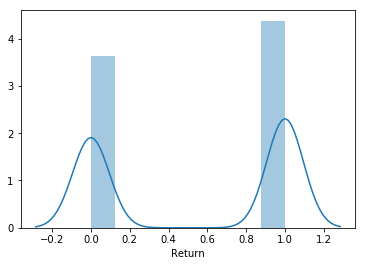

In [48]:
sns.distplot(y)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

### Build model

In [55]:
model = Sequential()
model.add(Dense(50, input_dim=X.shape[1]))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(40))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(30))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(20))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(5))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('tanh'))
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train.values, y_train.values, 
          validation_data=(X_test.values, y_test.values),
          epochs=3000, 
          batch_size=256, 
          verbose=2)

Train on 3212 samples, validate on 803 samples
Epoch 1/3000
1s - loss: 2.3933 - acc: 0.4664 - val_loss: 0.9520 - val_acc: 0.4184
Epoch 2/3000
0s - loss: 1.0289 - acc: 0.4894 - val_loss: 0.7927 - val_acc: 0.4745
Epoch 3/3000
0s - loss: 0.9707 - acc: 0.4935 - val_loss: 0.7749 - val_acc: 0.4807
Epoch 4/3000
0s - loss: 0.9088 - acc: 0.4984 - val_loss: 0.7855 - val_acc: 0.4545
Epoch 5/3000
0s - loss: 0.9060 - acc: 0.4795 - val_loss: 0.7946 - val_acc: 0.4545
Epoch 6/3000
0s - loss: 0.8884 - acc: 0.5003 - val_loss: 0.8008 - val_acc: 0.4384
Epoch 7/3000
0s - loss: 0.8554 - acc: 0.5006 - val_loss: 0.8056 - val_acc: 0.4384
Epoch 8/3000
0s - loss: 0.8571 - acc: 0.4841 - val_loss: 0.7996 - val_acc: 0.4359
Epoch 9/3000
0s - loss: 0.8341 - acc: 0.5012 - val_loss: 0.7933 - val_acc: 0.4321
Epoch 10/3000
0s - loss: 0.8233 - acc: 0.4872 - val_loss: 0.7890 - val_acc: 0.4296
Epoch 11/3000
0s - loss: 0.8099 - acc: 0.5016 - val_loss: 0.7820 - val_acc: 0.4271
Epoch 12/3000
0s - loss: 0.8003 - acc: 0.5003 - v

0s - loss: 0.6957 - acc: 0.5181 - val_loss: 0.6831 - val_acc: 0.5953
Epoch 103/3000
0s - loss: 0.6929 - acc: 0.5246 - val_loss: 0.6837 - val_acc: 0.5965
Epoch 104/3000
0s - loss: 0.6961 - acc: 0.5190 - val_loss: 0.6848 - val_acc: 0.5928
Epoch 105/3000
0s - loss: 0.6986 - acc: 0.5068 - val_loss: 0.6838 - val_acc: 0.5953
Epoch 106/3000
0s - loss: 0.6925 - acc: 0.5184 - val_loss: 0.6835 - val_acc: 0.5928
Epoch 107/3000
0s - loss: 0.6947 - acc: 0.5339 - val_loss: 0.6832 - val_acc: 0.5915
Epoch 108/3000
0s - loss: 0.6951 - acc: 0.5115 - val_loss: 0.6836 - val_acc: 0.5915
Epoch 109/3000
0s - loss: 0.6938 - acc: 0.5342 - val_loss: 0.6835 - val_acc: 0.5915
Epoch 110/3000
0s - loss: 0.6925 - acc: 0.5392 - val_loss: 0.6837 - val_acc: 0.5890
Epoch 111/3000
0s - loss: 0.6920 - acc: 0.5205 - val_loss: 0.6835 - val_acc: 0.5903
Epoch 112/3000
0s - loss: 0.6940 - acc: 0.5193 - val_loss: 0.6836 - val_acc: 0.5903
Epoch 113/3000
0s - loss: 0.6937 - acc: 0.5224 - val_loss: 0.6828 - val_acc: 0.5940
Epoch 1

0s - loss: 0.6869 - acc: 0.5324 - val_loss: 0.6842 - val_acc: 0.5753
Epoch 202/3000
0s - loss: 0.6816 - acc: 0.5523 - val_loss: 0.6838 - val_acc: 0.5753
Epoch 203/3000
0s - loss: 0.6843 - acc: 0.5495 - val_loss: 0.6835 - val_acc: 0.5853
Epoch 204/3000
0s - loss: 0.6829 - acc: 0.5470 - val_loss: 0.6833 - val_acc: 0.5866
Epoch 205/3000
0s - loss: 0.6857 - acc: 0.5498 - val_loss: 0.6838 - val_acc: 0.5816
Epoch 206/3000
0s - loss: 0.6841 - acc: 0.5423 - val_loss: 0.6840 - val_acc: 0.5791
Epoch 207/3000
0s - loss: 0.6837 - acc: 0.5495 - val_loss: 0.6846 - val_acc: 0.5729
Epoch 208/3000
0s - loss: 0.6850 - acc: 0.5461 - val_loss: 0.6837 - val_acc: 0.5803
Epoch 209/3000
0s - loss: 0.6856 - acc: 0.5420 - val_loss: 0.6856 - val_acc: 0.5616
Epoch 210/3000
0s - loss: 0.6900 - acc: 0.5346 - val_loss: 0.6847 - val_acc: 0.5741
Epoch 211/3000
0s - loss: 0.6870 - acc: 0.5436 - val_loss: 0.6849 - val_acc: 0.5729
Epoch 212/3000
0s - loss: 0.6815 - acc: 0.5532 - val_loss: 0.6829 - val_acc: 0.5816
Epoch 2

0s - loss: 0.6712 - acc: 0.5682 - val_loss: 0.6880 - val_acc: 0.5392
Epoch 301/3000
0s - loss: 0.6760 - acc: 0.5598 - val_loss: 0.6907 - val_acc: 0.5118
Epoch 302/3000
0s - loss: 0.6727 - acc: 0.5676 - val_loss: 0.6889 - val_acc: 0.5106
Epoch 303/3000
0s - loss: 0.6672 - acc: 0.5887 - val_loss: 0.6876 - val_acc: 0.5318
Epoch 304/3000
0s - loss: 0.6691 - acc: 0.5716 - val_loss: 0.6885 - val_acc: 0.5243
Epoch 305/3000
0s - loss: 0.6645 - acc: 0.5831 - val_loss: 0.6900 - val_acc: 0.5193
Epoch 306/3000
0s - loss: 0.6711 - acc: 0.5719 - val_loss: 0.6890 - val_acc: 0.5205
Epoch 307/3000
0s - loss: 0.6664 - acc: 0.5866 - val_loss: 0.6904 - val_acc: 0.5106
Epoch 308/3000
0s - loss: 0.6631 - acc: 0.5828 - val_loss: 0.6920 - val_acc: 0.5131
Epoch 309/3000
0s - loss: 0.6642 - acc: 0.5962 - val_loss: 0.6895 - val_acc: 0.5181
Epoch 310/3000
0s - loss: 0.6661 - acc: 0.5866 - val_loss: 0.6903 - val_acc: 0.5205
Epoch 311/3000
0s - loss: 0.6699 - acc: 0.5850 - val_loss: 0.6934 - val_acc: 0.5068
Epoch 3

0s - loss: 0.6560 - acc: 0.6071 - val_loss: 0.6985 - val_acc: 0.5081
Epoch 400/3000
0s - loss: 0.6469 - acc: 0.6121 - val_loss: 0.6957 - val_acc: 0.5193
Epoch 401/3000
0s - loss: 0.6605 - acc: 0.5934 - val_loss: 0.6977 - val_acc: 0.5118
Epoch 402/3000
0s - loss: 0.6537 - acc: 0.5971 - val_loss: 0.6948 - val_acc: 0.5205
Epoch 403/3000
0s - loss: 0.6502 - acc: 0.6155 - val_loss: 0.6940 - val_acc: 0.5280
Epoch 404/3000
0s - loss: 0.6476 - acc: 0.6208 - val_loss: 0.6962 - val_acc: 0.5293
Epoch 405/3000
0s - loss: 0.6561 - acc: 0.6068 - val_loss: 0.6981 - val_acc: 0.5181
Epoch 406/3000
0s - loss: 0.6535 - acc: 0.6090 - val_loss: 0.6974 - val_acc: 0.5131
Epoch 407/3000
0s - loss: 0.6494 - acc: 0.6124 - val_loss: 0.6983 - val_acc: 0.5044
Epoch 408/3000
0s - loss: 0.6508 - acc: 0.6062 - val_loss: 0.6975 - val_acc: 0.5081
Epoch 409/3000
0s - loss: 0.6501 - acc: 0.6130 - val_loss: 0.6983 - val_acc: 0.5081
Epoch 410/3000
0s - loss: 0.6536 - acc: 0.6027 - val_loss: 0.6954 - val_acc: 0.5280
Epoch 4

0s - loss: 0.6381 - acc: 0.6329 - val_loss: 0.7132 - val_acc: 0.5006
Epoch 499/3000
0s - loss: 0.6387 - acc: 0.6286 - val_loss: 0.7146 - val_acc: 0.4969
Epoch 500/3000
0s - loss: 0.6388 - acc: 0.6317 - val_loss: 0.7084 - val_acc: 0.5143
Epoch 501/3000
0s - loss: 0.6421 - acc: 0.6167 - val_loss: 0.7120 - val_acc: 0.5081
Epoch 502/3000
0s - loss: 0.6306 - acc: 0.6336 - val_loss: 0.7122 - val_acc: 0.4969
Epoch 503/3000
0s - loss: 0.6382 - acc: 0.6308 - val_loss: 0.7104 - val_acc: 0.5068
Epoch 504/3000
0s - loss: 0.6324 - acc: 0.6342 - val_loss: 0.7148 - val_acc: 0.4932
Epoch 505/3000
0s - loss: 0.6335 - acc: 0.6339 - val_loss: 0.7151 - val_acc: 0.5031
Epoch 506/3000
0s - loss: 0.6279 - acc: 0.6351 - val_loss: 0.7125 - val_acc: 0.5106
Epoch 507/3000
0s - loss: 0.6394 - acc: 0.6208 - val_loss: 0.7131 - val_acc: 0.5006
Epoch 508/3000
0s - loss: 0.6410 - acc: 0.6304 - val_loss: 0.7086 - val_acc: 0.5106
Epoch 509/3000
0s - loss: 0.6358 - acc: 0.6304 - val_loss: 0.7089 - val_acc: 0.5143
Epoch 5

0s - loss: 0.6283 - acc: 0.6401 - val_loss: 0.7172 - val_acc: 0.4956
Epoch 598/3000
0s - loss: 0.6252 - acc: 0.6510 - val_loss: 0.7178 - val_acc: 0.4969
Epoch 599/3000
0s - loss: 0.6230 - acc: 0.6385 - val_loss: 0.7113 - val_acc: 0.5006
Epoch 600/3000
0s - loss: 0.6205 - acc: 0.6466 - val_loss: 0.7105 - val_acc: 0.5081
Epoch 601/3000
0s - loss: 0.6184 - acc: 0.6395 - val_loss: 0.7225 - val_acc: 0.4969
Epoch 602/3000
0s - loss: 0.6295 - acc: 0.6473 - val_loss: 0.7229 - val_acc: 0.4857
Epoch 603/3000
0s - loss: 0.6245 - acc: 0.6357 - val_loss: 0.7173 - val_acc: 0.5006
Epoch 604/3000
0s - loss: 0.6280 - acc: 0.6342 - val_loss: 0.7182 - val_acc: 0.4857
Epoch 605/3000
0s - loss: 0.6273 - acc: 0.6389 - val_loss: 0.7208 - val_acc: 0.4894
Epoch 606/3000
0s - loss: 0.6306 - acc: 0.6398 - val_loss: 0.7214 - val_acc: 0.4894
Epoch 607/3000
0s - loss: 0.6303 - acc: 0.6392 - val_loss: 0.7170 - val_acc: 0.4969
Epoch 608/3000
0s - loss: 0.6274 - acc: 0.6392 - val_loss: 0.7163 - val_acc: 0.5019
Epoch 6

0s - loss: 0.6186 - acc: 0.6445 - val_loss: 0.7332 - val_acc: 0.4782
Epoch 697/3000
0s - loss: 0.6186 - acc: 0.6547 - val_loss: 0.7261 - val_acc: 0.4907
Epoch 698/3000
0s - loss: 0.6169 - acc: 0.6538 - val_loss: 0.7319 - val_acc: 0.4807
Epoch 699/3000
0s - loss: 0.6079 - acc: 0.6585 - val_loss: 0.7323 - val_acc: 0.4907
Epoch 700/3000
0s - loss: 0.6075 - acc: 0.6700 - val_loss: 0.7373 - val_acc: 0.4932
Epoch 701/3000
0s - loss: 0.6109 - acc: 0.6519 - val_loss: 0.7423 - val_acc: 0.4932
Epoch 702/3000
0s - loss: 0.6101 - acc: 0.6519 - val_loss: 0.7395 - val_acc: 0.4919
Epoch 703/3000
0s - loss: 0.6102 - acc: 0.6578 - val_loss: 0.7334 - val_acc: 0.4994
Epoch 704/3000
0s - loss: 0.6164 - acc: 0.6585 - val_loss: 0.7385 - val_acc: 0.4720
Epoch 705/3000
0s - loss: 0.6196 - acc: 0.6498 - val_loss: 0.7287 - val_acc: 0.4944
Epoch 706/3000
0s - loss: 0.6180 - acc: 0.6631 - val_loss: 0.7201 - val_acc: 0.5068
Epoch 707/3000
0s - loss: 0.6142 - acc: 0.6488 - val_loss: 0.7285 - val_acc: 0.4658
Epoch 7

0s - loss: 0.6118 - acc: 0.6572 - val_loss: 0.7401 - val_acc: 0.4745
Epoch 796/3000
0s - loss: 0.6098 - acc: 0.6544 - val_loss: 0.7327 - val_acc: 0.4981
Epoch 797/3000
0s - loss: 0.6116 - acc: 0.6613 - val_loss: 0.7325 - val_acc: 0.4944
Epoch 798/3000
0s - loss: 0.6117 - acc: 0.6554 - val_loss: 0.7317 - val_acc: 0.4944
Epoch 799/3000
0s - loss: 0.6194 - acc: 0.6538 - val_loss: 0.7390 - val_acc: 0.4695
Epoch 800/3000
0s - loss: 0.6128 - acc: 0.6656 - val_loss: 0.7401 - val_acc: 0.4795
Epoch 801/3000
0s - loss: 0.6120 - acc: 0.6519 - val_loss: 0.7395 - val_acc: 0.4844
Epoch 802/3000
0s - loss: 0.6095 - acc: 0.6628 - val_loss: 0.7365 - val_acc: 0.4882
Epoch 803/3000
0s - loss: 0.6050 - acc: 0.6631 - val_loss: 0.7409 - val_acc: 0.4969
Epoch 804/3000
0s - loss: 0.6066 - acc: 0.6644 - val_loss: 0.7441 - val_acc: 0.4682
Epoch 805/3000
0s - loss: 0.6050 - acc: 0.6628 - val_loss: 0.7406 - val_acc: 0.4844
Epoch 806/3000
0s - loss: 0.6029 - acc: 0.6591 - val_loss: 0.7351 - val_acc: 0.4832
Epoch 8

0s - loss: 0.6034 - acc: 0.6715 - val_loss: 0.7514 - val_acc: 0.4645
Epoch 895/3000
0s - loss: 0.6021 - acc: 0.6694 - val_loss: 0.7556 - val_acc: 0.4508
Epoch 896/3000
0s - loss: 0.6041 - acc: 0.6641 - val_loss: 0.7527 - val_acc: 0.4583
Epoch 897/3000
0s - loss: 0.5977 - acc: 0.6734 - val_loss: 0.7543 - val_acc: 0.4446
Epoch 898/3000
0s - loss: 0.6114 - acc: 0.6575 - val_loss: 0.7463 - val_acc: 0.4583
Epoch 899/3000
0s - loss: 0.6008 - acc: 0.6697 - val_loss: 0.7415 - val_acc: 0.4645
Epoch 900/3000
0s - loss: 0.6025 - acc: 0.6687 - val_loss: 0.7456 - val_acc: 0.4620
Epoch 901/3000
0s - loss: 0.6039 - acc: 0.6684 - val_loss: 0.7520 - val_acc: 0.4533
Epoch 902/3000
0s - loss: 0.5934 - acc: 0.6768 - val_loss: 0.7459 - val_acc: 0.4695
Epoch 903/3000
0s - loss: 0.6011 - acc: 0.6638 - val_loss: 0.7563 - val_acc: 0.4433
Epoch 904/3000
0s - loss: 0.5966 - acc: 0.6734 - val_loss: 0.7544 - val_acc: 0.4558
Epoch 905/3000
0s - loss: 0.5997 - acc: 0.6771 - val_loss: 0.7527 - val_acc: 0.4595
Epoch 9

0s - loss: 0.5989 - acc: 0.6669 - val_loss: 0.7387 - val_acc: 0.4496
Epoch 994/3000
0s - loss: 0.5823 - acc: 0.6877 - val_loss: 0.7453 - val_acc: 0.4558
Epoch 995/3000
0s - loss: 0.5950 - acc: 0.6684 - val_loss: 0.7583 - val_acc: 0.4595
Epoch 996/3000
0s - loss: 0.6047 - acc: 0.6722 - val_loss: 0.7522 - val_acc: 0.4633
Epoch 997/3000
0s - loss: 0.5878 - acc: 0.6818 - val_loss: 0.7464 - val_acc: 0.4732
Epoch 998/3000
0s - loss: 0.5993 - acc: 0.6678 - val_loss: 0.7495 - val_acc: 0.4720
Epoch 999/3000
0s - loss: 0.6008 - acc: 0.6715 - val_loss: 0.7504 - val_acc: 0.4745
Epoch 1000/3000
0s - loss: 0.5901 - acc: 0.6768 - val_loss: 0.7431 - val_acc: 0.4844
Epoch 1001/3000
0s - loss: 0.5914 - acc: 0.6821 - val_loss: 0.7483 - val_acc: 0.4732
Epoch 1002/3000
0s - loss: 0.6065 - acc: 0.6588 - val_loss: 0.7469 - val_acc: 0.4745
Epoch 1003/3000
0s - loss: 0.5982 - acc: 0.6672 - val_loss: 0.7495 - val_acc: 0.4570
Epoch 1004/3000
0s - loss: 0.5880 - acc: 0.6818 - val_loss: 0.7478 - val_acc: 0.4745
Ep

0s - loss: 0.5857 - acc: 0.6862 - val_loss: 0.7520 - val_acc: 0.4869
Epoch 1092/3000
0s - loss: 0.5910 - acc: 0.6771 - val_loss: 0.7524 - val_acc: 0.4819
Epoch 1093/3000
0s - loss: 0.5886 - acc: 0.6908 - val_loss: 0.7551 - val_acc: 0.4770
Epoch 1094/3000
0s - loss: 0.5913 - acc: 0.6775 - val_loss: 0.7498 - val_acc: 0.4819
Epoch 1095/3000
0s - loss: 0.5833 - acc: 0.6834 - val_loss: 0.7530 - val_acc: 0.4757
Epoch 1096/3000
0s - loss: 0.5932 - acc: 0.6834 - val_loss: 0.7524 - val_acc: 0.4770
Epoch 1097/3000
0s - loss: 0.5806 - acc: 0.6896 - val_loss: 0.7495 - val_acc: 0.4782
Epoch 1098/3000
0s - loss: 0.5859 - acc: 0.6837 - val_loss: 0.7524 - val_acc: 0.4770
Epoch 1099/3000
0s - loss: 0.5879 - acc: 0.6887 - val_loss: 0.7523 - val_acc: 0.4670
Epoch 1100/3000
0s - loss: 0.5932 - acc: 0.6809 - val_loss: 0.7554 - val_acc: 0.4658
Epoch 1101/3000
0s - loss: 0.5908 - acc: 0.6828 - val_loss: 0.7459 - val_acc: 0.4782
Epoch 1102/3000
0s - loss: 0.5879 - acc: 0.6862 - val_loss: 0.7565 - val_acc: 0.4

0s - loss: 0.5876 - acc: 0.6828 - val_loss: 0.7596 - val_acc: 0.4670
Epoch 1191/3000
0s - loss: 0.5972 - acc: 0.6775 - val_loss: 0.7588 - val_acc: 0.4558
Epoch 1192/3000
0s - loss: 0.5926 - acc: 0.6796 - val_loss: 0.7446 - val_acc: 0.4658
Epoch 1193/3000
0s - loss: 0.5935 - acc: 0.6818 - val_loss: 0.7566 - val_acc: 0.4658
Epoch 1194/3000
0s - loss: 0.5864 - acc: 0.6887 - val_loss: 0.7647 - val_acc: 0.4608
Epoch 1195/3000
0s - loss: 0.5963 - acc: 0.6728 - val_loss: 0.7582 - val_acc: 0.4633
Epoch 1196/3000
0s - loss: 0.5857 - acc: 0.6834 - val_loss: 0.7557 - val_acc: 0.4695
Epoch 1197/3000
0s - loss: 0.5839 - acc: 0.6912 - val_loss: 0.7576 - val_acc: 0.4682
Epoch 1198/3000
0s - loss: 0.5911 - acc: 0.6834 - val_loss: 0.7573 - val_acc: 0.4608
Epoch 1199/3000
0s - loss: 0.5754 - acc: 0.6949 - val_loss: 0.7610 - val_acc: 0.4608
Epoch 1200/3000
0s - loss: 0.5901 - acc: 0.6946 - val_loss: 0.7673 - val_acc: 0.4558
Epoch 1201/3000
0s - loss: 0.5842 - acc: 0.6880 - val_loss: 0.7704 - val_acc: 0.4

0s - loss: 0.5908 - acc: 0.6756 - val_loss: 0.7579 - val_acc: 0.4757
Epoch 1289/3000
0s - loss: 0.5767 - acc: 0.6952 - val_loss: 0.7585 - val_acc: 0.4757
Epoch 1290/3000
0s - loss: 0.5826 - acc: 0.6890 - val_loss: 0.7704 - val_acc: 0.4645
Epoch 1291/3000
0s - loss: 0.5881 - acc: 0.6831 - val_loss: 0.7707 - val_acc: 0.4645
Epoch 1292/3000
0s - loss: 0.5840 - acc: 0.6915 - val_loss: 0.7541 - val_acc: 0.4819
Epoch 1293/3000
0s - loss: 0.5931 - acc: 0.6880 - val_loss: 0.7621 - val_acc: 0.4670
Epoch 1294/3000
0s - loss: 0.5925 - acc: 0.6796 - val_loss: 0.7603 - val_acc: 0.4570
Epoch 1295/3000
0s - loss: 0.5792 - acc: 0.6952 - val_loss: 0.7675 - val_acc: 0.4545
Epoch 1296/3000
0s - loss: 0.5798 - acc: 0.6946 - val_loss: 0.7565 - val_acc: 0.4832
Epoch 1297/3000
0s - loss: 0.5849 - acc: 0.6921 - val_loss: 0.7635 - val_acc: 0.4695
Epoch 1298/3000
0s - loss: 0.5897 - acc: 0.6818 - val_loss: 0.7688 - val_acc: 0.4658
Epoch 1299/3000
0s - loss: 0.5816 - acc: 0.6871 - val_loss: 0.7558 - val_acc: 0.4

0s - loss: 0.5888 - acc: 0.6815 - val_loss: 0.7610 - val_acc: 0.4633
Epoch 1388/3000
0s - loss: 0.5901 - acc: 0.6821 - val_loss: 0.7617 - val_acc: 0.4558
Epoch 1389/3000
0s - loss: 0.5854 - acc: 0.6856 - val_loss: 0.7613 - val_acc: 0.4533
Epoch 1390/3000
0s - loss: 0.5759 - acc: 0.6902 - val_loss: 0.7665 - val_acc: 0.4545
Epoch 1391/3000
0s - loss: 0.5807 - acc: 0.6890 - val_loss: 0.7766 - val_acc: 0.4558
Epoch 1392/3000
0s - loss: 0.5862 - acc: 0.6803 - val_loss: 0.7655 - val_acc: 0.4533
Epoch 1393/3000
0s - loss: 0.5807 - acc: 0.6924 - val_loss: 0.7685 - val_acc: 0.4633
Epoch 1394/3000
0s - loss: 0.5879 - acc: 0.6803 - val_loss: 0.7611 - val_acc: 0.4570
Epoch 1395/3000
0s - loss: 0.5746 - acc: 0.7008 - val_loss: 0.7580 - val_acc: 0.4595
Epoch 1396/3000
0s - loss: 0.5934 - acc: 0.6740 - val_loss: 0.7652 - val_acc: 0.4583
Epoch 1397/3000
0s - loss: 0.5801 - acc: 0.7002 - val_loss: 0.7577 - val_acc: 0.4608
Epoch 1398/3000
0s - loss: 0.5876 - acc: 0.6824 - val_loss: 0.7622 - val_acc: 0.4

0s - loss: 0.5854 - acc: 0.6915 - val_loss: 0.7611 - val_acc: 0.4720
Epoch 1487/3000
0s - loss: 0.5796 - acc: 0.6977 - val_loss: 0.7602 - val_acc: 0.4695
Epoch 1488/3000
0s - loss: 0.5833 - acc: 0.6880 - val_loss: 0.7674 - val_acc: 0.4695
Epoch 1489/3000
0s - loss: 0.5808 - acc: 0.6890 - val_loss: 0.7612 - val_acc: 0.4795
Epoch 1490/3000
0s - loss: 0.5767 - acc: 0.6921 - val_loss: 0.7739 - val_acc: 0.4732
Epoch 1491/3000
0s - loss: 0.5689 - acc: 0.7027 - val_loss: 0.7774 - val_acc: 0.4682
Epoch 1492/3000
0s - loss: 0.5803 - acc: 0.6946 - val_loss: 0.7698 - val_acc: 0.4832
Epoch 1493/3000
0s - loss: 0.5734 - acc: 0.7045 - val_loss: 0.7696 - val_acc: 0.4682
Epoch 1494/3000
0s - loss: 0.5749 - acc: 0.6933 - val_loss: 0.7715 - val_acc: 0.4670
Epoch 1495/3000
0s - loss: 0.5736 - acc: 0.7083 - val_loss: 0.7731 - val_acc: 0.4670
Epoch 1496/3000
0s - loss: 0.5830 - acc: 0.6887 - val_loss: 0.7733 - val_acc: 0.4695
Epoch 1497/3000
0s - loss: 0.5909 - acc: 0.6856 - val_loss: 0.7601 - val_acc: 0.4

0s - loss: 0.5736 - acc: 0.6927 - val_loss: 0.7626 - val_acc: 0.4770
Epoch 1586/3000
0s - loss: 0.5613 - acc: 0.7064 - val_loss: 0.7681 - val_acc: 0.4795
Epoch 1587/3000
0s - loss: 0.5781 - acc: 0.6943 - val_loss: 0.7659 - val_acc: 0.4795
Epoch 1588/3000
0s - loss: 0.5888 - acc: 0.6815 - val_loss: 0.7542 - val_acc: 0.4720
Epoch 1589/3000
0s - loss: 0.5794 - acc: 0.6877 - val_loss: 0.7636 - val_acc: 0.4608
Epoch 1590/3000
0s - loss: 0.5890 - acc: 0.6815 - val_loss: 0.7655 - val_acc: 0.4633
Epoch 1591/3000
0s - loss: 0.5826 - acc: 0.6933 - val_loss: 0.7736 - val_acc: 0.4583
Epoch 1592/3000
0s - loss: 0.5780 - acc: 0.6965 - val_loss: 0.7666 - val_acc: 0.4670
Epoch 1593/3000
0s - loss: 0.5773 - acc: 0.6924 - val_loss: 0.7675 - val_acc: 0.4620
Epoch 1594/3000
0s - loss: 0.5700 - acc: 0.6943 - val_loss: 0.7737 - val_acc: 0.4732
Epoch 1595/3000
0s - loss: 0.5650 - acc: 0.7139 - val_loss: 0.7725 - val_acc: 0.4757
Epoch 1596/3000
0s - loss: 0.5661 - acc: 0.7036 - val_loss: 0.7800 - val_acc: 0.4

0s - loss: 0.5713 - acc: 0.7052 - val_loss: 0.7822 - val_acc: 0.4545
Epoch 1685/3000
0s - loss: 0.5817 - acc: 0.6837 - val_loss: 0.7732 - val_acc: 0.4595
Epoch 1686/3000
0s - loss: 0.5759 - acc: 0.7052 - val_loss: 0.7698 - val_acc: 0.4707
Epoch 1687/3000
0s - loss: 0.5758 - acc: 0.7033 - val_loss: 0.7686 - val_acc: 0.4720
Epoch 1688/3000
0s - loss: 0.5735 - acc: 0.7002 - val_loss: 0.7753 - val_acc: 0.4720
Epoch 1689/3000
0s - loss: 0.5776 - acc: 0.7021 - val_loss: 0.7680 - val_acc: 0.4757
Epoch 1690/3000
0s - loss: 0.5714 - acc: 0.7024 - val_loss: 0.7701 - val_acc: 0.4658
Epoch 1691/3000
0s - loss: 0.5694 - acc: 0.7105 - val_loss: 0.7742 - val_acc: 0.4670
Epoch 1692/3000
0s - loss: 0.5759 - acc: 0.6958 - val_loss: 0.7798 - val_acc: 0.4570
Epoch 1693/3000
0s - loss: 0.5737 - acc: 0.6999 - val_loss: 0.7710 - val_acc: 0.4558
Epoch 1694/3000
0s - loss: 0.5702 - acc: 0.6983 - val_loss: 0.7680 - val_acc: 0.4707
Epoch 1695/3000
0s - loss: 0.5744 - acc: 0.6887 - val_loss: 0.7823 - val_acc: 0.4

0s - loss: 0.5748 - acc: 0.6949 - val_loss: 0.7830 - val_acc: 0.4707
Epoch 1784/3000
0s - loss: 0.5699 - acc: 0.7089 - val_loss: 0.7644 - val_acc: 0.4844
Epoch 1785/3000
0s - loss: 0.5674 - acc: 0.7021 - val_loss: 0.7728 - val_acc: 0.4770
Epoch 1786/3000
0s - loss: 0.5660 - acc: 0.7073 - val_loss: 0.7689 - val_acc: 0.4757
Epoch 1787/3000
0s - loss: 0.5710 - acc: 0.7108 - val_loss: 0.7609 - val_acc: 0.4819
Epoch 1788/3000
0s - loss: 0.5711 - acc: 0.7011 - val_loss: 0.7690 - val_acc: 0.4745
Epoch 1789/3000
0s - loss: 0.5571 - acc: 0.7207 - val_loss: 0.7781 - val_acc: 0.4770
Epoch 1790/3000
0s - loss: 0.5640 - acc: 0.7117 - val_loss: 0.7779 - val_acc: 0.4745
Epoch 1791/3000
0s - loss: 0.5747 - acc: 0.7049 - val_loss: 0.7829 - val_acc: 0.4682
Epoch 1792/3000
0s - loss: 0.5688 - acc: 0.7030 - val_loss: 0.7737 - val_acc: 0.4745
Epoch 1793/3000
0s - loss: 0.5676 - acc: 0.7064 - val_loss: 0.7727 - val_acc: 0.4844
Epoch 1794/3000
0s - loss: 0.5745 - acc: 0.6977 - val_loss: 0.7671 - val_acc: 0.4

0s - loss: 0.5772 - acc: 0.6905 - val_loss: 0.7689 - val_acc: 0.4857
Epoch 1883/3000
0s - loss: 0.5740 - acc: 0.7014 - val_loss: 0.7777 - val_acc: 0.4832
Epoch 1884/3000
0s - loss: 0.5712 - acc: 0.7042 - val_loss: 0.7809 - val_acc: 0.4732
Epoch 1885/3000
0s - loss: 0.5721 - acc: 0.6952 - val_loss: 0.7928 - val_acc: 0.4608
Epoch 1886/3000
0s - loss: 0.5749 - acc: 0.7101 - val_loss: 0.7755 - val_acc: 0.4720
Epoch 1887/3000
0s - loss: 0.5577 - acc: 0.7117 - val_loss: 0.7767 - val_acc: 0.4770
Epoch 1888/3000
0s - loss: 0.5632 - acc: 0.7033 - val_loss: 0.7973 - val_acc: 0.4645
Epoch 1889/3000
0s - loss: 0.5755 - acc: 0.6961 - val_loss: 0.7687 - val_acc: 0.4795
Epoch 1890/3000
0s - loss: 0.5707 - acc: 0.6971 - val_loss: 0.7705 - val_acc: 0.4857
Epoch 1891/3000
0s - loss: 0.5686 - acc: 0.7033 - val_loss: 0.7833 - val_acc: 0.4844
Epoch 1892/3000
0s - loss: 0.5675 - acc: 0.7033 - val_loss: 0.7799 - val_acc: 0.4757
Epoch 1893/3000
0s - loss: 0.5682 - acc: 0.7027 - val_loss: 0.7798 - val_acc: 0.4

0s - loss: 0.5871 - acc: 0.6949 - val_loss: 0.7697 - val_acc: 0.4745
Epoch 1982/3000
0s - loss: 0.5627 - acc: 0.7061 - val_loss: 0.7771 - val_acc: 0.4795
Epoch 1983/3000
0s - loss: 0.5672 - acc: 0.7033 - val_loss: 0.7775 - val_acc: 0.4807
Epoch 1984/3000
0s - loss: 0.5611 - acc: 0.7117 - val_loss: 0.7802 - val_acc: 0.4770
Epoch 1985/3000
0s - loss: 0.5690 - acc: 0.7049 - val_loss: 0.7790 - val_acc: 0.4620
Epoch 1986/3000
0s - loss: 0.5615 - acc: 0.7105 - val_loss: 0.7758 - val_acc: 0.4682
Epoch 1987/3000
0s - loss: 0.5589 - acc: 0.7151 - val_loss: 0.7777 - val_acc: 0.4732
Epoch 1988/3000
0s - loss: 0.5681 - acc: 0.7058 - val_loss: 0.7884 - val_acc: 0.4682
Epoch 1989/3000
0s - loss: 0.5759 - acc: 0.6961 - val_loss: 0.7721 - val_acc: 0.4745
Epoch 1990/3000
0s - loss: 0.5573 - acc: 0.7192 - val_loss: 0.7839 - val_acc: 0.4732
Epoch 1991/3000
0s - loss: 0.5728 - acc: 0.6961 - val_loss: 0.7788 - val_acc: 0.4707
Epoch 1992/3000
0s - loss: 0.5580 - acc: 0.7192 - val_loss: 0.7729 - val_acc: 0.4

0s - loss: 0.5653 - acc: 0.7101 - val_loss: 0.7921 - val_acc: 0.4695
Epoch 2081/3000
0s - loss: 0.5818 - acc: 0.6993 - val_loss: 0.7845 - val_acc: 0.4707
Epoch 2082/3000
0s - loss: 0.5567 - acc: 0.7176 - val_loss: 0.7800 - val_acc: 0.4695
Epoch 2083/3000
0s - loss: 0.5792 - acc: 0.6977 - val_loss: 0.7806 - val_acc: 0.4608
Epoch 2084/3000
0s - loss: 0.5689 - acc: 0.7145 - val_loss: 0.7803 - val_acc: 0.4732
Epoch 2085/3000
0s - loss: 0.5572 - acc: 0.7151 - val_loss: 0.7832 - val_acc: 0.4770
Epoch 2086/3000
0s - loss: 0.5727 - acc: 0.6996 - val_loss: 0.7873 - val_acc: 0.4595
Epoch 2087/3000
0s - loss: 0.5566 - acc: 0.7117 - val_loss: 0.7831 - val_acc: 0.4670
Epoch 2088/3000
0s - loss: 0.5698 - acc: 0.7064 - val_loss: 0.7825 - val_acc: 0.4645
Epoch 2089/3000
0s - loss: 0.5636 - acc: 0.7158 - val_loss: 0.7823 - val_acc: 0.4595
Epoch 2090/3000
0s - loss: 0.5694 - acc: 0.6983 - val_loss: 0.7847 - val_acc: 0.4633
Epoch 2091/3000
0s - loss: 0.5688 - acc: 0.7036 - val_loss: 0.7815 - val_acc: 0.4

0s - loss: 0.5833 - acc: 0.7008 - val_loss: 0.7739 - val_acc: 0.4608
Epoch 2180/3000
0s - loss: 0.5670 - acc: 0.7061 - val_loss: 0.7695 - val_acc: 0.4633
Epoch 2181/3000
0s - loss: 0.5636 - acc: 0.7164 - val_loss: 0.7844 - val_acc: 0.4595
Epoch 2182/3000
0s - loss: 0.5732 - acc: 0.7042 - val_loss: 0.7817 - val_acc: 0.4670
Epoch 2183/3000
0s - loss: 0.5647 - acc: 0.7105 - val_loss: 0.7779 - val_acc: 0.4670
Epoch 2184/3000
0s - loss: 0.5694 - acc: 0.7083 - val_loss: 0.7788 - val_acc: 0.4757
Epoch 2185/3000
0s - loss: 0.5701 - acc: 0.7030 - val_loss: 0.7822 - val_acc: 0.4745
Epoch 2186/3000
0s - loss: 0.5698 - acc: 0.7011 - val_loss: 0.7839 - val_acc: 0.4545
Epoch 2187/3000
0s - loss: 0.5659 - acc: 0.7080 - val_loss: 0.7777 - val_acc: 0.4620
Epoch 2188/3000
0s - loss: 0.5654 - acc: 0.7058 - val_loss: 0.7814 - val_acc: 0.4633
Epoch 2189/3000
0s - loss: 0.5479 - acc: 0.7198 - val_loss: 0.7934 - val_acc: 0.4570
Epoch 2190/3000
0s - loss: 0.5679 - acc: 0.7061 - val_loss: 0.7990 - val_acc: 0.4

0s - loss: 0.5527 - acc: 0.7313 - val_loss: 0.7849 - val_acc: 0.4857
Epoch 2279/3000
0s - loss: 0.5561 - acc: 0.7123 - val_loss: 0.7843 - val_acc: 0.4857
Epoch 2280/3000
0s - loss: 0.5572 - acc: 0.7092 - val_loss: 0.7853 - val_acc: 0.4857
Epoch 2281/3000
0s - loss: 0.5674 - acc: 0.7095 - val_loss: 0.7770 - val_acc: 0.4770
Epoch 2282/3000
0s - loss: 0.5688 - acc: 0.6965 - val_loss: 0.7656 - val_acc: 0.4882
Epoch 2283/3000
0s - loss: 0.5687 - acc: 0.7055 - val_loss: 0.7720 - val_acc: 0.4807
Epoch 2284/3000
0s - loss: 0.5636 - acc: 0.7101 - val_loss: 0.7825 - val_acc: 0.4732
Epoch 2285/3000
0s - loss: 0.5608 - acc: 0.7098 - val_loss: 0.7832 - val_acc: 0.4707
Epoch 2286/3000
0s - loss: 0.5635 - acc: 0.7123 - val_loss: 0.7913 - val_acc: 0.4670
Epoch 2287/3000
0s - loss: 0.5512 - acc: 0.7207 - val_loss: 0.7760 - val_acc: 0.4819
Epoch 2288/3000
0s - loss: 0.5639 - acc: 0.7117 - val_loss: 0.7845 - val_acc: 0.4707
Epoch 2289/3000
0s - loss: 0.5680 - acc: 0.7039 - val_loss: 0.7860 - val_acc: 0.4

In [53]:
predicted = model.predict(X_test.values)

In [54]:
model.evaluate(X_test.values, y_test.values, verbose=3)

[1.2061833503979675, 0.48941469489414696]